In [507]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import numpy as np
import random

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

random.seed(67890)

In [508]:
class Robot(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.box_carried = False

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False)
        if not self.box_carried:
            possible_steps = [
                pos for pos in possible_steps if self.model.is_box(pos)] or possible_steps
        elif self.box_carried:
            possible_steps = [
                pos for pos in possible_steps if self.model.boxes[pos[0]][pos[1]] < 5] or possible_steps
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def step(self):
        if not self.box_carried and self.model.is_box(self.pos):
            self.box_carried = True
            self.model.pick_box(self.pos)
        elif self.box_carried and self.model.boxes[self.pos[0]][self.pos[1]] < 5:
            self.box_carried = False
            self.model.place_box(self.pos)
        self.move()

In [509]:
def get_grid(model):
    grid = np.full((model.width, model.height), 0)
    for i in range(model.grid.width):
        for j in range(model.grid.height):
            if model.boxes[i][j] > 0:
                grid[i][j] = model.boxes[i][j]
    for (cell_content, (x,y)) in model.grid.coord_iter():
        if cell_content:
            grid[x][y] = 7
    
    return grid

In [510]:
class WarehouseModel(Model):
    def __init__(self, width, height, num_agents, num_boxes):
        self.width = width
        self.height = height
        self.num_agents = num_agents
        self.num_boxes = num_boxes
        self.boxes = np.zeros((width, height))

        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        # Place agents
        robotId = 0
        for _ in range(self.num_agents):
            a = Robot(robotId, self)
            self.schedule.add(a)
            pos = self.random_empty_cell()
            while self.is_box(pos):
                pos = self.random_empty_cell()
            self.grid.place_agent(a, pos)
            robotId += 1

        # Place boxes
        for _ in range(self.num_boxes):
            pos = self.random_position()
            while self.init_full(pos):
                pos = self.random_position()
            self.boxes[pos[0]][pos[1]] += 1

    def is_box(self, pos):
        return self.boxes[pos[0]][pos[1]] > 0
    
    def init_full(self, pos):
        return self.boxes[pos[0]][pos[1]] == 3

    def pick_box(self, pos):
        if self.is_box(pos):
            self.boxes[pos[0]][pos[1]] -= 1

    def place_box(self, pos):
        self.boxes[pos[0]][pos[1]] += 1

    def count_carried_boxes(self):
        return sum(agent.box_carried for agent in self.schedule.agents)

    def random_empty_cell(self):
        empty_cells = [(x, y) for x in range(self.width) for y in range(self.height) if self.grid.is_cell_empty((x, y))]
        if not empty_cells:
            raise Exception("No empty cells available.")
        return random.choice(empty_cells)
    
    def random_position(self):
        x = random.randint(0, self.width - 1)
        y = random.randint(0, self.height - 1)
        return (x, y)

    def is_simulation_done(self):
        return np.all(np.logical_or(self.boxes == 0, self.boxes == 5))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [511]:
WIDTH = 2
HEIGHT = 2
NUM_AGENTS = 1
NUM_BOXES = 1

In [512]:
model = WarehouseModel(WIDTH, HEIGHT, NUM_AGENTS, NUM_BOXES)
for i in range(100):
    model.step()

data = model.datacollector.get_model_vars_dataframe()
data

,Grid
0,"[[0, 7], [0, 0]]"
1,"[[0, 0], [0, 7]]"
2,"[[0, 0], [7, 1]]"
3,"[[0, 0], [0, 7]]"
4,"[[0, 0], [7, 0]]"
...,...
95,"[[0, 1], [0, 7]]"
96,"[[0, 7], [0, 0]]"
97,"[[0, 0], [0, 7]]"
98,"[[0, 0], [7, 1]]"


C:\Users\santi\AppData\Local\Temp\ipykernel_12864\293235668.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(data.iloc[0][0], cmap=plt.cm.binary)
C:\Users\santi\AppData\Local\Temp\ipykernel_12864\293235668.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[frame][0])


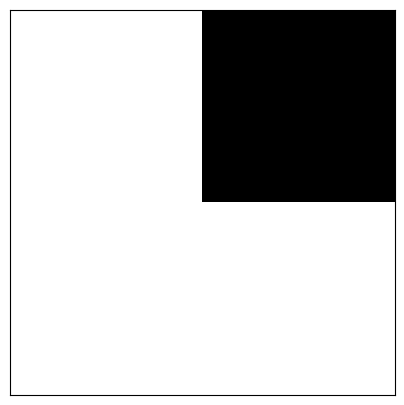

In [513]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(data.iloc[0][0], cmap=plt.cm.binary)

def animate(frame):
    patch.set_data(data.iloc[frame][0])

anim = animation.FuncAnimation(fig, animate, frames=100, interval=100)